# Elo Score Calculation

In [1]:
import re
import os
import sys
from collections import defaultdict

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import xlrd

In [4]:
# setting path
sys.path.append('../../src')

In [5]:
from eloscore import eloscore

In [6]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data for One Sheet

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [7]:
xls = pd.ExcelFile("./data/Reward_Competition_Scoring_MasterList.xlsx")
sheets = xls.sheet_names

In [8]:
sheets

['Master Assignment List',
 'Jocelyn',
 'Ezra',
 'Albert',
 'Isabel',
 'Catalina',
 'Meghan',
 'Erika',
 'Naeliz']

In [9]:
reward_competition_df = pd.read_excel("./data/Reward_Competition_Scoring_MasterList.xlsx", sheet_name=sheets[0], header=0)

In [10]:
reward_competition_df.head()

,Date,Cage,Box,Match,Scorer,Trial 1 Time,Trial 1 Winner,Trial 2 Time,Trial 2 Winner,Trial 3 Time,...,Trial 17 Time,Trial 17 Winner,Trial 18 Time,Trial 18 Winner,Trial 19 Time,Trial 19 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties,
0,2022-07-28,1,1,1v2,Naeliz,0:48-0:58,2,1:56-2:04,1,3:09-3:18,...,20:53-21:00,1,22:33-22:42,1,23:39-23:47,1,NaN,NaN,NaN,NaN
1,2022-07-28,1,2,3v4,Erika,0:47-0:53,3,1:54-2:00,4,3:09-3:15,...,20:53-20:59,3,22:33-22:39,4,23:39-23:45,4,8.0,11.0,0.0,NaN
2,2022-07-28,1,3,2v3,Ezra,00:37-00:43,2,1:31-1:37,2,2:30-2:36,...,16:42-16:48,3,18:02-18:08,tie,18:55-19:01,tie,12.0,3.0,4.0,NaN
3,2022-07-28,1,4,1v4,Isabel,0:37-0:44,1,1:31-1:38,1,2:31-2:38,...,16:43-16:49,4,18:02-18:09,1,20:36-20:43,1,18.0,1.0,NaN,NaN
4,2022-07-28,1,1,2v4,Catalina,0:47 - 0:56,2,1:54 - 2:02,2,3:09 - 3:17,...,20:52 - 21:00,2,22:32 - 22:40,tie,23:39 - 23:47,tie,11.0,3.0,5.0,NaN


In [74]:
reward_competition_df.tail()

,index,Date,Cage,Box,Match,Scorer,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,...,Trial 11 Winner,Trial 12 Winner,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,animal_ids
67,67,2022-07-29,6,2,2v4,Isabel,4,4,4,4,...,4,4,4,4,4,4,4,4,4,"{2, 4}"
68,68,2022-07-29,6,3,1v4,Catalina,1,1,1,4,...,1,1,1,1,1,1,1,1,1,"{1, 4}"
69,69,2022-07-29,6,4,2v3,Erika,2,3,3,3,...,2,3,2,2,2,3,3,3,3,"{2, 3}"
70,70,2022-07-29,6,1,3v4,Ezra,4,tie,3,3,...,4,3,3,3,3,3,4,tie,3,"{4, 3}"
71,71,2022-07-29,6,1,1v2,Jocelyn,1,1,2,1,...,2,1,tie,2,2,2,2,1,1,"{2, 1}"


In [11]:
reward_competition_df.columns

Index(['Date', 'Cage', 'Box', 'Match', 'Scorer', 'Trial 1 Time',
       'Trial 1 Winner', 'Trial 2 Time ', 'Trial 2 Winner', 'Trial 3 Time',
       'Trial 3 Winner', 'Trial 4 Time', 'Trial 4 Winner', 'Trial 5 Time',
       'Trial 5 Winner', 'Trial 6 Time', 'Trial 6 Winner', 'Trial 7 Time',
       'Trial 7 Winner', 'Trial 8 Time', 'Trial 8 Winner', 'Trial 9 Time',
       'Trial 9 Winner', 'Trial 10 Time ', 'Trial 10 Winner', 'Trial 11 Time',
       'Trial 11 Winner', 'Trial 12 Time ', 'Trial 12 Winner', 'Trial 13 Time',
       'Trial 13 Winner', 'Trial 14 Time', 'Trial 14 Winner', 'Trial 15 Time',
       'Trial 15 Winner', 'Trial 16 Time ', 'Trial 16 Winner', 'Trial 17 Time',
       'Trial 17 Winner', 'Trial 18 Time', 'Trial 18 Winner', 'Trial 19 Time',
       'Trial 19 Winner', 'Mouse 1 Wins', 'Mouse 2 Wins', 'Ties', ' '],
      dtype='object')

In [12]:
reward_competition_df = reward_competition_df.dropna(subset=["Trial 1 Winner"])

## Removing Unnecessary Columns

In [13]:
reward_competition_df.columns

Index(['Date', 'Cage', 'Box', 'Match', 'Scorer', 'Trial 1 Time',
       'Trial 1 Winner', 'Trial 2 Time ', 'Trial 2 Winner', 'Trial 3 Time',
       'Trial 3 Winner', 'Trial 4 Time', 'Trial 4 Winner', 'Trial 5 Time',
       'Trial 5 Winner', 'Trial 6 Time', 'Trial 6 Winner', 'Trial 7 Time',
       'Trial 7 Winner', 'Trial 8 Time', 'Trial 8 Winner', 'Trial 9 Time',
       'Trial 9 Winner', 'Trial 10 Time ', 'Trial 10 Winner', 'Trial 11 Time',
       'Trial 11 Winner', 'Trial 12 Time ', 'Trial 12 Winner', 'Trial 13 Time',
       'Trial 13 Winner', 'Trial 14 Time', 'Trial 14 Winner', 'Trial 15 Time',
       'Trial 15 Winner', 'Trial 16 Time ', 'Trial 16 Winner', 'Trial 17 Time',
       'Trial 17 Winner', 'Trial 18 Time', 'Trial 18 Winner', 'Trial 19 Time',
       'Trial 19 Winner', 'Mouse 1 Wins', 'Mouse 2 Wins', 'Ties', ' '],
      dtype='object')

In [14]:
reward_competition_df = reward_competition_df.drop(["Mouse 1 Wins", "Mouse 2 Wins", "Ties", " "], axis=1, errors="ignore")

In [15]:
columns_to_keep = [col for col in reward_competition_df.columns if "time" not in col.lower().strip()]

In [16]:
columns_to_keep

['Date',
 'Cage',
 'Box',
 'Match',
 'Scorer',
 'Trial 1 Winner',
 'Trial 2 Winner',
 'Trial 3 Winner',
 'Trial 4 Winner',
 'Trial 5 Winner',
 'Trial 6 Winner',
 'Trial 7 Winner',
 'Trial 8 Winner',
 'Trial 9 Winner',
 'Trial 10 Winner',
 'Trial 11 Winner',
 'Trial 12 Winner',
 'Trial 13 Winner',
 'Trial 14 Winner',
 'Trial 15 Winner',
 'Trial 16 Winner',
 'Trial 17 Winner',
 'Trial 18 Winner',
 'Trial 19 Winner']

In [17]:
reward_competition_df = reward_competition_df[columns_to_keep].copy()

In [18]:
reward_competition_df.head()

,Date,Cage,Box,Match,Scorer,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,Trial 5 Winner,...,Trial 10 Winner,Trial 11 Winner,Trial 12 Winner,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner
0,2022-07-28,1,1,1v2,Naeliz,2,1,1,2,2,...,1,1,2,1,1,2,1,1,1,1
1,2022-07-28,1,2,3v4,Erika,3,4,4,3,4,...,4,4,3,3,4,3,3,3,4,4
2,2022-07-28,1,3,2v3,Ezra,2,2,2,2,2,...,2,2,2,tie,2,3,tie,3,tie,tie
3,2022-07-28,1,4,1v4,Isabel,1,1,1,1,1,...,1,1,1,1,1,1,1,4,1,1
4,2022-07-28,1,1,2v4,Catalina,2,2,4,2,4,...,2,2,2,tie,tie,tie,2,2,tie,tie


In [19]:
reward_competition_df = reward_competition_df.dropna(subset=["Trial 1 Winner"])

## Add both IDs as a column

In [20]:
reward_competition_df["animal_ids"] = reward_competition_df["Match"].apply(lambda x: set(x.split("v")))

In [21]:
reward_competition_df.head()

,Date,Cage,Box,Match,Scorer,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,Trial 5 Winner,...,Trial 11 Winner,Trial 12 Winner,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,animal_ids
0,2022-07-28,1,1,1v2,Naeliz,2,1,1,2,2,...,1,2,1,1,2,1,1,1,1,"{2, 1}"
1,2022-07-28,1,2,3v4,Erika,3,4,4,3,4,...,4,3,3,4,3,3,3,4,4,"{4, 3}"
2,2022-07-28,1,3,2v3,Ezra,2,2,2,2,2,...,2,2,tie,2,3,tie,3,tie,tie,"{2, 3}"
3,2022-07-28,1,4,1v4,Isabel,1,1,1,1,1,...,1,1,1,1,1,1,4,1,1,"{1, 4}"
4,2022-07-28,1,1,2v4,Catalina,2,2,4,2,4,...,2,2,tie,tie,tie,2,2,tie,tie,"{2, 4}"


## Melt 

In [22]:
reward_competition_df = reward_competition_df.reset_index()

In [23]:
reward_competition_df.head()

,index,Date,Cage,Box,Match,Scorer,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,...,Trial 11 Winner,Trial 12 Winner,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,animal_ids
0,0,2022-07-28,1,1,1v2,Naeliz,2,1,1,2,...,1,2,1,1,2,1,1,1,1,"{2, 1}"
1,1,2022-07-28,1,2,3v4,Erika,3,4,4,3,...,4,3,3,4,3,3,3,4,4,"{4, 3}"
2,2,2022-07-28,1,3,2v3,Ezra,2,2,2,2,...,2,2,tie,2,3,tie,3,tie,tie,"{2, 3}"
3,3,2022-07-28,1,4,1v4,Isabel,1,1,1,1,...,1,1,1,1,1,1,4,1,1,"{1, 4}"
4,4,2022-07-28,1,1,2v4,Catalina,2,2,4,2,...,2,2,tie,tie,tie,2,2,tie,tie,"{2, 4}"


In [24]:
melted_reward_competition_df = reward_competition_df.melt(id_vars=["index", "Date", "Cage", "Box", "Match", "Scorer", "animal_ids"], 
        var_name="Trial", 
        value_name="Winner")

In [25]:
melted_reward_competition_df.head()

,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,Winner
0,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,2
1,1,2022-07-28,1,2,3v4,Erika,"{4, 3}",Trial 1 Winner,3
2,2,2022-07-28,1,3,2v3,Ezra,"{2, 3}",Trial 1 Winner,2
3,3,2022-07-28,1,4,1v4,Isabel,"{1, 4}",Trial 1 Winner,1
4,4,2022-07-28,1,1,2v4,Catalina,"{2, 4}",Trial 1 Winner,2


- Dropping all rows that don't contain Winner

In [26]:
melted_reward_competition_df = melted_reward_competition_df.dropna(subset="Winner")

- Getting the number of the trial so that we can order by number(instead of string, which would make 11 come before 2)

In [27]:
melted_reward_competition_df["trial_number"] = melted_reward_competition_df["Trial"].apply(lambda x: int(x.lower().strip("trial").strip("winner")))

In [28]:
melted_reward_competition_df = melted_reward_competition_df.sort_values(["index", "trial_number"])

In [29]:
melted_reward_competition_df.head()

,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,Winner,trial_number
0,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,2,1
72,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 2 Winner,1,2
144,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 3 Winner,1,3
216,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 4 Winner,2,4
288,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 5 Winner,2,5


In [30]:
melted_reward_competition_df["trial_number"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [31]:
melted_reward_competition_df["winner_id"] = melted_reward_competition_df["Winner"].astype(str).apply(lambda x: x.split(".")[0])

In [32]:
melted_reward_competition_df["Winner"].unique()

array([2, 1, 'tie', 3, 4, 'tie '], dtype=object)

- Dropping all rows that don't have numbers as IDs for the winner column

In [33]:
melted_reward_competition_df = melted_reward_competition_df[pd.to_numeric(melted_reward_competition_df['winner_id'], errors='coerce').notnull()]

## Add a column for the loser ID

In [34]:
melted_reward_competition_df.columns

Index(['index', 'Date', 'Cage', 'Box', 'Match', 'Scorer', 'animal_ids',
       'Trial', 'Winner', 'trial_number', 'winner_id'],
      dtype='object')

In [35]:
melted_reward_competition_df.head()

,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,Winner,trial_number,winner_id
0,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,2,1,2
72,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 2 Winner,1,2,1
144,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 3 Winner,1,3,1
216,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 4 Winner,2,4,2
288,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 5 Winner,2,5,2


In [36]:
melted_reward_competition_df["loser_id"] = melted_reward_competition_df.apply(lambda x: (list(x["animal_ids"] - set(x["winner_id"]))[0]), axis=1)

In [37]:
melted_reward_competition_df["winner_id"].unique()

array(['2', '1', '3', '4'], dtype=object)

In [38]:
melted_reward_competition_df["loser_id"].unique()

array(['1', '2', '4', '3'], dtype=object)

In [39]:
melted_reward_competition_df.head(n=5)

,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,Winner,trial_number,winner_id,loser_id
0,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,2,1,2,1
72,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 2 Winner,1,2,1,2
144,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 3 Winner,1,3,1,2
216,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 4 Winner,2,4,2,1
288,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 5 Winner,2,5,2,1


In [40]:
melted_reward_competition_df.tail(n=5)

,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,Winner,trial_number,winner_id,loser_id
1079,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 15 Winner,2,15,2,1
1151,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 16 Winner,2,16,2,1
1223,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 17 Winner,2,17,2,1
1295,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 18 Winner,1,18,1,2
1367,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 19 Winner,1,19,1,2


## Calculating ELO Score

- Example calculation

In [41]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1020

## Get the Elo score for all the events

In [42]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [43]:
cage_to_elo_score_dict = defaultdict(dict)
for cage in melted_reward_competition_df["Cage"].unique():
    cage_df = melted_reward_competition_df[melted_reward_competition_df["Cage"] == cage]
    cage_to_elo_score_dict[cage] = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=cage_df, winner_column="winner_id", loser_column="loser_id", additional_columns=["index", "Date", "Cage", "Box", "Match", "Scorer", "animal_ids", "Trial","trial_number"])

In [44]:
cage_to_elo_score_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [45]:
cage_to_elo_score_dict[list(cage_to_elo_score_dict.keys())[0]][0]

{'total_match_number': 1,
 'subject_id': '2',
 'agent_id': '1',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'index': 0,
 'Date': Timestamp('2022-07-28 00:00:00'),
 'Cage': 1,
 'Box': 1,
 'Match': '1v2',
 'Scorer': 'Naeliz',
 'animal_ids': {'1', '2'},
 'Trial': 'Trial 1 Winner',
 'trial_number': 1}

In [46]:
cage_to_elo_score_dict[1][2000]

{}

- Turning the dictionary into a dataframe

In [47]:
all_cage_elo_score_list = []
for key in cage_to_elo_score_dict.keys():
    cage_elo_score_df = pd.DataFrame.from_dict(cage_to_elo_score_dict[key], orient="index")
    cage_elo_score_df.insert(0, 'total_trial_number', range(0, 0 + len(cage_elo_score_df)))
    print(cage_elo_score_df)
    all_cage_elo_score_list.append(cage_elo_score_df)


     total_trial_number  total_match_number subject_id agent_id  \
0                     0                   1          2        1   
1                     1                   1          1        1   
2                     2                   2          1        2   
3                     3                   2          2        2   
4                     4                   3          1        2   
..                  ...                 ...        ...      ...   
403                 403                 202          1        1   
404                 404                 203          2        1   
405                 405                 203          1        1   
406                 406                 204          2        1   
407                 407                 204          1        1   

     original_elo_score  updated_elo_score  win_draw_loss  index       Date  \
0                1000.0             1010.0              1      0 2022-07-28   
1                1000.0              

In [48]:
all_cage_elo_score_df = pd.concat(all_cage_elo_score_list)

In [49]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,trial_number
0,0,1,2,1,1000.0,1010.0,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,1
1,1,1,1,1,1000.0,990.0,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,1
2,2,2,1,2,990.0,1000.6,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 2 Winner,2
3,3,2,2,2,1010.0,999.4,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 2 Winner,2
4,4,3,1,2,1000.6,1010.6,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 3 Winner,3


In [50]:
all_cage_elo_score_df.tail()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,trial_number
417,417,209,1,1,1112.2,1097.6,1,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 17 Winner,17
418,418,210,1,2,1097.6,1103.7,1,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 18 Winner,18
419,419,210,2,2,955.5,949.4,1,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 18 Winner,18
420,420,211,1,2,1103.7,1109.5,1,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 19 Winner,19
421,421,211,2,2,949.4,943.6,1,71,2022-07-29,6,1,1v2,Jocelyn,"{2, 1}",Trial 19 Winner,19


## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [51]:
all_cage_elo_score_df["id_with_cage_number"] = all_cage_elo_score_df.apply(lambda x: str(x["Cage"]) + "." + str(x["subject_id"]), axis = 1)


In [52]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,index,Date,Cage,Box,Match,Scorer,animal_ids,Trial,trial_number,id_with_cage_number
0,0,1,2,1,1000.0,1010.0,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,1,1.2
1,1,1,1,1,1000.0,990.0,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 1 Winner,1,1.1
2,2,2,1,2,990.0,1000.6,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 2 Winner,2,1.1
3,3,2,2,2,1010.0,999.4,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 2 Winner,2,1.2
4,4,3,1,2,1000.6,1010.6,1,0,2022-07-28,1,1,1v2,Naeliz,"{2, 1}",Trial 3 Winner,3,1.1


In [53]:
id_to_final_elo_score_dict = defaultdict(dict)
for id_with_cage_number in all_cage_elo_score_df["id_with_cage_number"].unique():
    per_subject_df = all_cage_elo_score_df[all_cage_elo_score_df["id_with_cage_number"] == id_with_cage_number]
    id_to_final_elo_score_dict[id_with_cage_number]["final_elo_score"] = per_subject_df.iloc[-1]["updated_elo_score"]

In [54]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
id_to_final_elo_score_df["experiment_type"] = "reward_competition"

In [55]:
id_to_final_elo_score_df["id_with_cage_number"] = id_to_final_elo_score_df.index
id_to_final_elo_score_df = id_to_final_elo_score_df.reset_index(drop=True)

In [56]:
id_to_final_elo_score_df.head()

,final_elo_score,experiment_type,id_with_cage_number
0,1151.5,reward_competition,1.1
1,1042.1,reward_competition,1.2
2,899.9,reward_competition,1.3
3,906.5,reward_competition,1.4
4,784.4,reward_competition,2.1


# Plotting the Elo Score by match number

In [57]:
all_cages = "_".join([str(cage) for cage in sorted(all_cage_elo_score_df["Cage"].unique())])

In [58]:
all_cages

'1_2_3_4_5_6'

In [59]:
earliest_date = all_cage_elo_score_df["Date"].min()
latest_date = all_cage_elo_score_df["Date"].max()

In [60]:
earliest_date = str(earliest_date.date()).replace("-", "")

In [61]:
latest_date = str(latest_date.date()).replace("-", "")

In [62]:
earliest_date

'20220728'

In [63]:
latest_date

'20220729'

In [64]:
output_directory = "./proc/plots/reward_competition/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [65]:
output_directory

'./proc/plots/reward_competition/cage_1_2_3_4_5_6_date_20220728_20220729'

In [66]:
os.makedirs(output_directory, exist_ok=True)

In [67]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

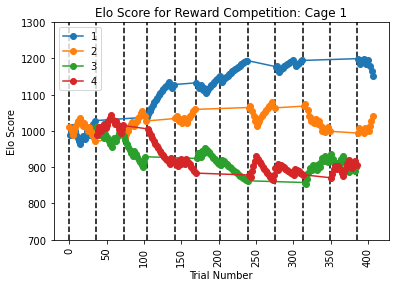

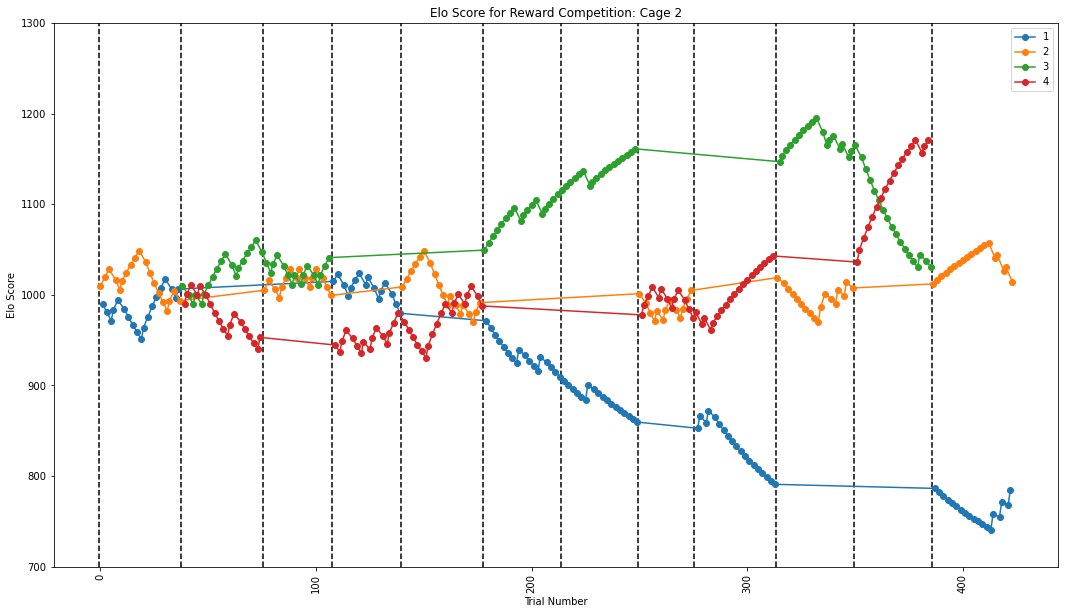

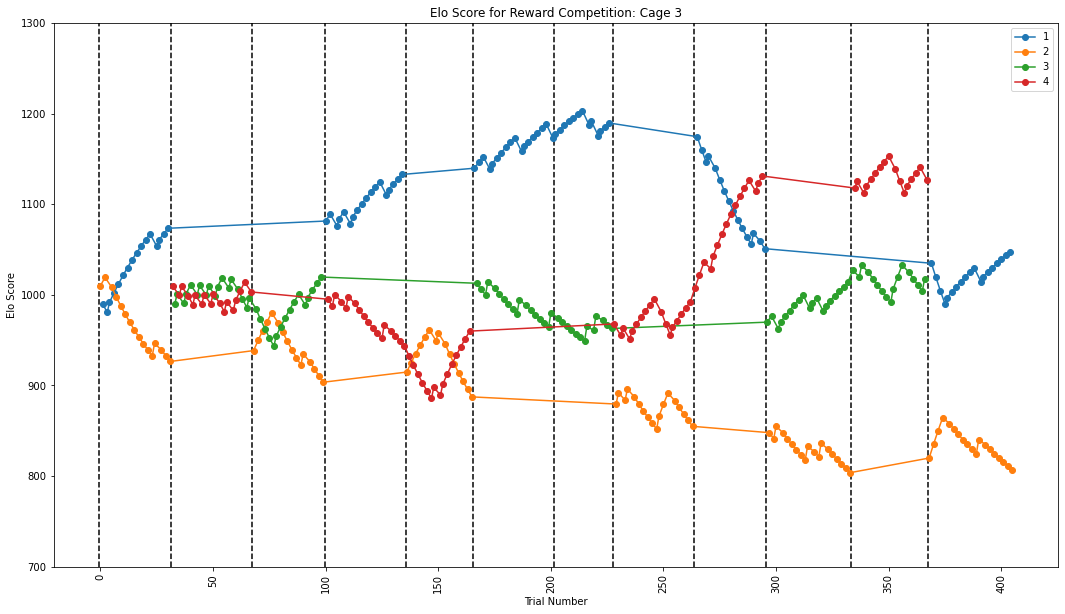

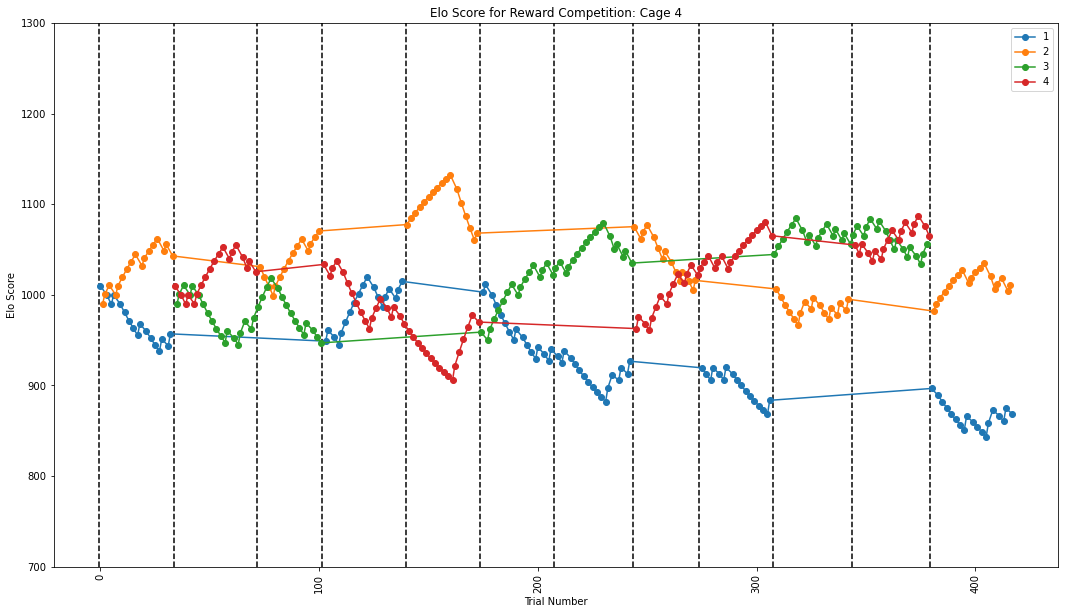

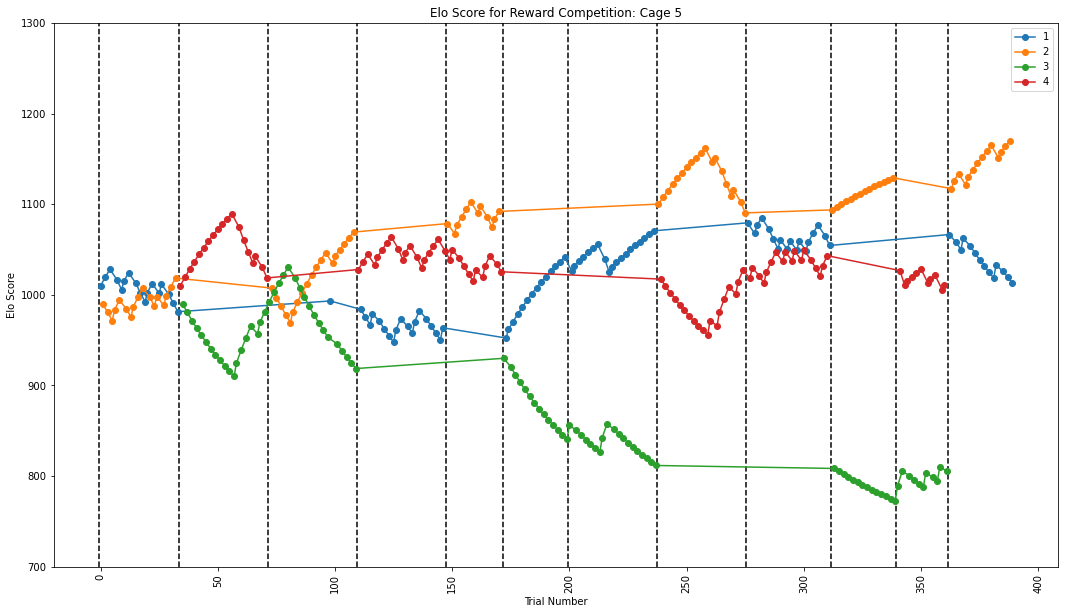

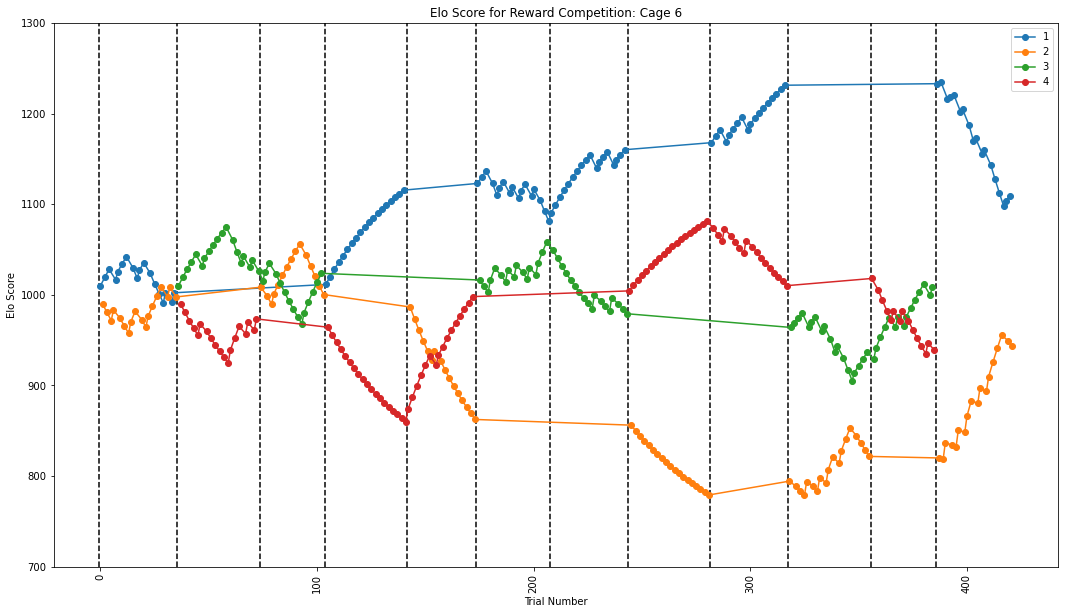

In [68]:
for cage in all_cage_elo_score_df["Cage"].unique():
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (18,10)
    per_cage_df = all_cage_elo_score_df[all_cage_elo_score_df["Cage"] == cage]
       
    for index in per_cage_df["index"].unique():
        first_session_in_trial = per_cage_df[per_cage_df["index"] == index].iloc[0]["total_trial_number"]
        plt.vlines(x=[first_session_in_trial - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

    
    
    # Drawing a line for each subject
    for subject in sorted(per_cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = per_cage_df[per_cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_trial_number"], subject_df["updated_elo_score"], '-o', label=subject)
    
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Reward Competition: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "reward_competition_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join(output_directory, file_name))  
    
    plt.show()

# Saving the Dataframes

In [69]:
output_directory = "./proc/elo_score_spread_sheets/reward_competition_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [70]:
output_directory

'./proc/elo_score_spread_sheets/reward_competition_elo_score/cage_1_2_3_4_5_6_date_20220728_20220729'

In [71]:
os.makedirs(output_directory, exist_ok=True)

In [72]:
file_name = "reward_competition_elo_score_history_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
all_cage_elo_score_df.to_csv(os.path.join(output_directory, file_name))

In [73]:
file_name = "reward_competition_final_elo_score_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(output_directory, file_name))